<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/advanced/HW04_recon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyWavelets

In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
import pywt

In [4]:
d = sio.loadmat('kspace_2d_fft_5echo.mat')
kspace = d['kspace']
Ns = 2
Ne = 4
M = np.abs(np.fft.fftshift(np.fft.fftn(np.fft.fftshift(kspace[:,:,Ns,Ne]))))
F = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(M)))

## Randomly Undersampled MR image
- Fourier domain에서 random undersampling이 image에 미치는 영향을 이해하기

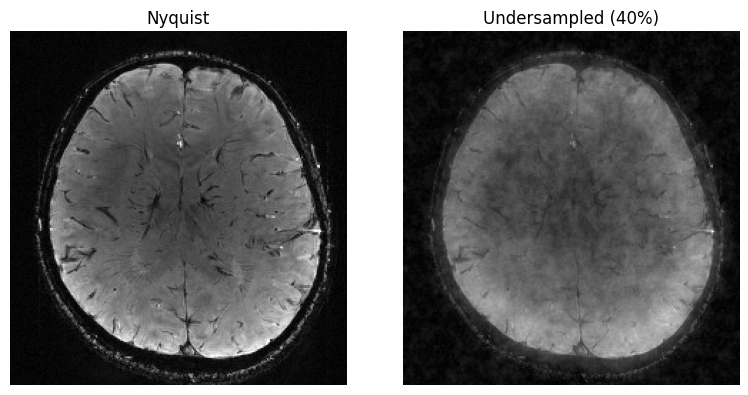

In [5]:
Us = np.zeros_like(F)
num_pixels_to_change = int(len(Us.ravel()) * 0.4)
indices = np.random.choice(len(Us.ravel()), size=num_pixels_to_change, replace=False)
Us.flat[indices] = 1
Us[160-8:160+8,160-8:160+8]=1

Fu = F * Us
Mu = np.abs(np.fft.fftshift(np.fft.fftn(np.fft.fftshift(Fu))))

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(M[48:-24,42:-42], cmap='gray',vmin=0,vmax=2)
plt.title('Nyquist')
plt.axis('off')

plt.subplot(122)
plt.imshow(Mu[48:-24,42:-42], cmap='gray',vmin=0,vmax=2)
plt.title('Undersampled (40%)')
plt.axis('off')

plt.tight_layout()
plt.show()

## wavelet transform의 이해
- 데이터에 대해 적절한 level 및 threshold 를 고민해보기

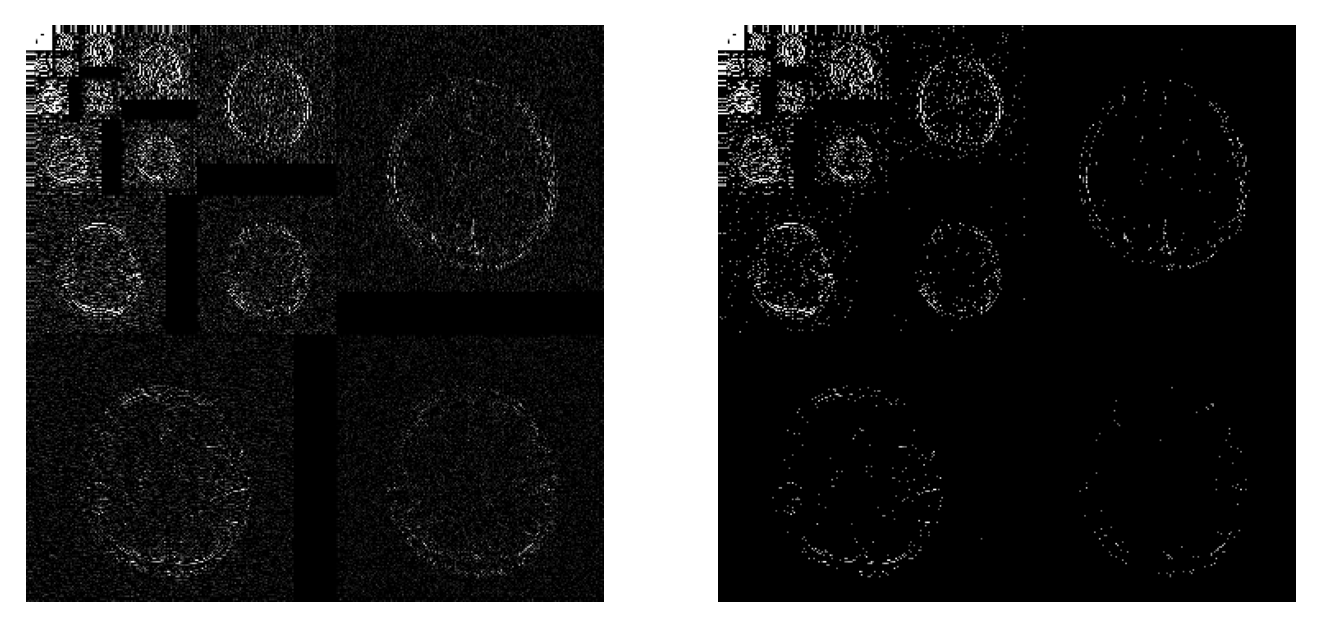

In [6]:
TH = 0.1
N_lev = 5

coeffs = pywt.wavedec2(Mu, 'db4', level=N_lev)
arr, slices = pywt.coeffs_to_array(coeffs)
plt.figure(dpi=256)
plt.subplot(121)
plt.imshow(arr,cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')
arr[arr<TH] = 0
plt.subplot(122)
plt.imshow(arr,cmap='gray',vmin=0,vmax=0.25)
plt.axis('off')
plt.show()

## Wavelet-based CS reconstruction (iterative)
- iteration, threshold, levels 등을 적절하게 조절하여 undersampled data로부터 복원영상의 품질을 높이자.

iteration 0


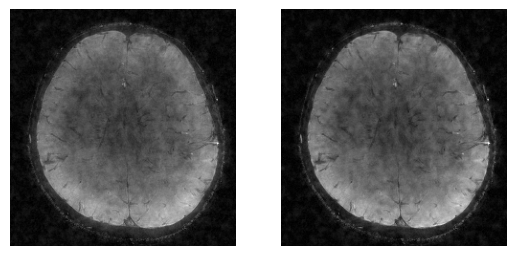

iteration 1


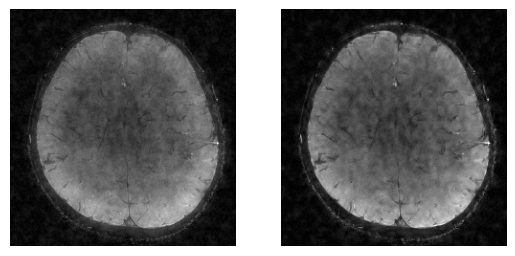

In [9]:
max_iter = 2
TH = 0.15
N_lev = 2

disp_interval = 1

Mu_rec = Mu.copy()
for i in range(max_iter):
    coeffs = pywt.wavedec2(Mu_rec, 'db4', level=N_lev)
    arr, slices = pywt.coeffs_to_array(coeffs)
    arr = pywt.threshold(arr, TH, mode='soft')

    coeffs_thresh = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
    Mu_rec = pywt.waverec2(coeffs_thresh, 'db4')

    F_est = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(Mu_rec)))
    F_est[Us==1] = Fu[Us==1]

    Mu_rec = np.abs(np.fft.fftshift(np.fft.fftn(np.fft.fftshift((F_est)))))

    if i % disp_interval == 0:
      print(f'iteration {i}')
      plt.subplot(121)
      plt.imshow(Mu[48:-24,42:-42],cmap='gray',vmin=0,vmax=2)
      plt.axis('off')
      plt.subplot(122)
      plt.imshow(Mu_rec[48:-24,42:-42],cmap='gray',vmin=0,vmax=2)
      plt.axis('off')
      plt.show()

## Results
- Nyquist sampling으로 얻어진 image와 undersampled data로부터 CS recon.을 통해 복원한 image의 차이를 비교해보기.
- Nyquist sampled image 대비 Mean absolute error를 zero-filled recon.의 경우와 비교해보자.

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(M[48:-24,42:-42], cmap='gray',vmin=0,vmax=2)
plt.title('Nyquist')
plt.axis('off')

plt.subplot(132)
plt.imshow(Mu[48:-24,42:-42], cmap='gray',vmin=0,vmax=2)
plt.title('Zero-filled')
plt.axis('off')

plt.subplot(133)
plt.imshow(Mu_rec[48:-24,42:-42], cmap='gray',vmin=0,vmax=2)
plt.title('CS Recon.')
plt.axis('off')

plt.tight_layout()
plt.show()

L1_zf = np.mean(np.abs(M-Mu))
L1_cs = np.mean(np.abs(M-Mu_rec))

print('## L1 error ##')
print(f'- Zero-filled: {L1_zf}')
print(f'- CS Recon.: {L1_cs}')